# Финальное задание по теме обработки изображений
В этом задании вы напишете класс Dataset для задачи сегментации. 

В папке Train_Data находятся изображения. В input — картинки с котиками, в mask — маски изображений. Критерий правильно написанного класса — у вас запустилось обучение.

Датасет небольшой, поэтому не удивляйтесь, что сегментация будет не очень точной, но отрисуйте пару сегментированных котиков. 

Для начала скачайте датасет и положите его на свой Google-диск. 

# Загрузка датасета

Разархивируем наш датасет

In [146]:
!wget https://raw.githubusercontent.com/data-science-misis/cv/main/Train_Data.zip
!unzip -q -o './Train_Data'

--2021-11-14 14:12:43--  https://raw.githubusercontent.com/evsikov/datasets/main/Train_Data.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2284761 (2.2M) [application/zip]
Saving to: ‘Train_Data.zip.3’

Train_Data.zip.3    100%[===================>]   2.18M  --.-KB/s    in 0.06s   

2021-11-14 14:12:43 (35.5 MB/s) - ‘Train_Data.zip.3’ saved [2284761/2284761]



Импортируем нужные библиотеки

In [147]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt


Для решения задачи сегментации будем использовать известную архитектуру Unet.

# UNet архитектура

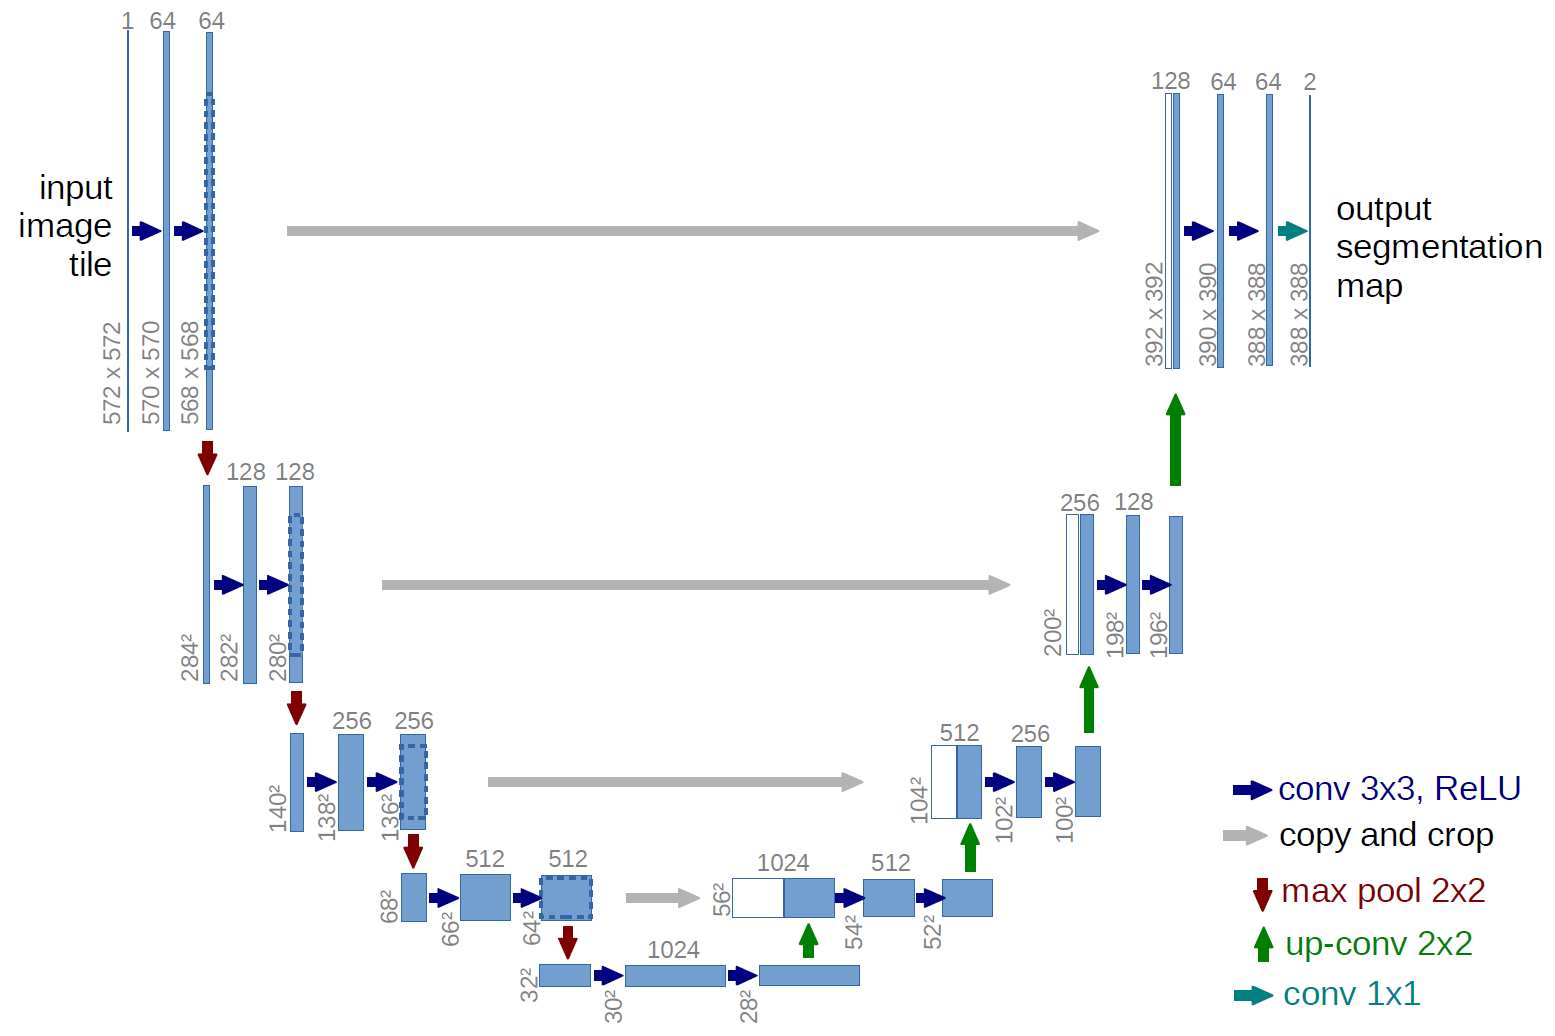

Архитектура UNet используется для сегментации картинок и представляет собой сверточную нейросеть.

Так выглядит архитектура UNet, реализованная в виде кода.

In [148]:
class UNet(nn.Module):
    def __init__(self, n_channels, n_classes, bilinear=True):
        super(UNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear

        self.inc = DoubleConv(n_channels, 64)
        self.down1 = Down(64, 128)
        self.down2 = Down(128, 256)
        self.down3 = Down(256, 512)
        factor = 2 if bilinear else 1
        self.down4 = Down(512, 1024 // factor)
        self.up1 = Up(1024, 512 // factor, bilinear)
        self.up2 = Up(512, 256 // factor, bilinear)
        self.up3 = Up(256, 128 // factor, bilinear)
        self.up4 = Up(128, 64, bilinear)
        self.outc = OutConv(64, n_classes)

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        logits = self.outc(x)
        return logits

Это была общая архитектура. Подробнее об ней вы можете прочитать [здесь](https://lmb.informatik.uni-freiburg.de/people/ronneber/u-net/).

Теперь необходимо реализовать отдельные ее блоки.

DoubleConv — блок, состоящий из повторяющихся друг за другом послежовательностей конволюция -> нормализация по батчам -> активация ReLU.

In [149]:
class DoubleConv(nn.Module):
    """(convolution => [BN] => ReLU) * 2"""

    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)


Down — один шажок Downsampling, или понижения размерности. Состоит из пулинга и представленной выше двойной конволюции.

In [150]:
class Down(nn.Module):
    """Downscaling with maxpool then double conv"""

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)

Up — обратная операция, повышение размерности.

In [151]:
class Up(nn.Module):
    """Upscaling then double conv"""

    def __init__(self, in_channels, out_channels, bilinear=True):
        super().__init__()

        # if bilinear, use the normal convolutions to reduce the number of channels
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
            self.conv = DoubleConv(in_channels, out_channels, in_channels // 2)
        else:
            self.up = nn.ConvTranspose2d(in_channels , in_channels // 2, kernel_size=2, stride=2)
            self.conv = DoubleConv(in_channels, out_channels)


    def forward(self, x1, x2):
        x1 = self.up(x1)
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])
        
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)


class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)

# Класс Dataset

Реализуйте свой класс DataSet

In [152]:
inputs = '/content/Train_Data/input'
masks = '/content/Train_Data/mask'

In [153]:
class my_dataset(torch.utils.data.Dataset):
    def __init__(self, path_to_images, path_to_masks):
        self.path_to_images = path_to_images
        self.path_to_masks = path_to_masks
        sorted_images = sorted(os.listdir(path_to_images))
        sorted_masks = sorted(os.listdir(path_to_masks))

        self.image_paths = [f"{path_to_images}/{name}" for name in sorted_images if os.path.isfile(f"{path_to_images}/{name}")]
        self.mask_paths = [f"{path_to_masks}/{name}" for name in sorted_masks if os.path.isfile(f"{path_to_masks}/{name}")]
        self.len = len(self.image_paths)
        import torchvision.transforms as transforms
        self.trans = transforms.Compose([transforms.ToTensor(), 
                                        transforms.Resize(size=(256,256))])

    def __len__(self):
        return self.len


    def __getitem__ (self, idx):
        image = cv2.imread(self.image_paths[idx])
        mask = cv2.imread(self.mask_paths[idx])
        # print(f"Loaded {image} and {mask} from {self.image_paths[idx]} and {self.mask_paths[idx]}")

        data = self.trans(image)
        target = self.trans(mask)
        
        return (data, target)
        # from PIL import Image
        # data = Image.open(self.image_paths[idx])
        # data = self.trans(data)
        # target = Image.open(self.mask_paths[idx])
        # target = self.trans(target)
        # print(data.shape, target.shape)
        # return (data, target)
              
train_dataset = my_dataset(inputs, masks)
    
train_batch_gen = torch.utils.data.DataLoader(train_dataset, batch_size=5, shuffle=True)

# Обучение модели

In [154]:
def compute_loss(y_pred, y_true):
    return -torch.mean(torch.sum(y_true*torch.log(F.softmax(y_pred,dim=0)),dim=0))

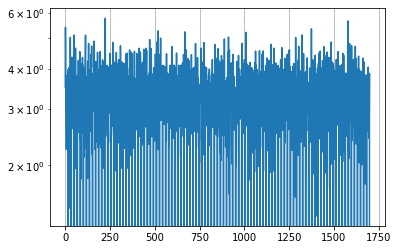

In [156]:
import time
from IPython.display import clear_output
model = UNet(n_channels=3,n_classes = 1);#UNet(n_class = 2);
model.cuda()
opt = torch.optim.Adam(model.parameters())

num_epochs = 100 # 400
train_loss = []

for i in range(num_epochs):
    start_time = time.time()
    model.train(True)
    for (X_batch, y_batch) in train_batch_gen:
        print(X_batch.size())
        X_batch, y_batch = X_batch.cuda(), y_batch.cuda()
        loss = compute_loss(model(X_batch),y_batch)
        loss.backward()
        opt.step()
        opt.zero_grad()
        
        error = loss.item()
        train_loss.append(error)
        
        clear_output(True)
        plt.semilogy(train_loss)
        plt.grid()
        plt.show()
    

# Оценка результатов

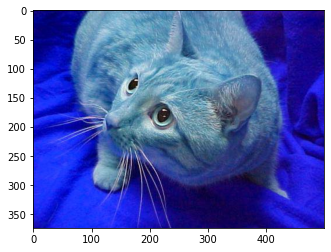

In [157]:
im = cv2.imread('/content/Train_Data/input/cat.18.jpg')
plt.imshow(im)


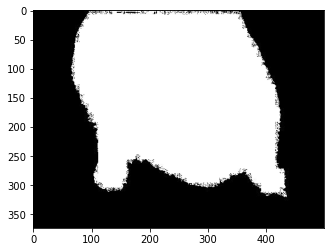

In [158]:
mask_im = cv2.imread('/content/Train_Data/mask/mask_cat.18.jpg')
plt.imshow(mask_im)

In [159]:
import torchvision.transforms as transforms
image_transform_f = transforms.Compose([transforms.ToTensor(), 
                                        transforms.Resize(size=(256,256))])

In [160]:
transformed = image_transform_f(im)
transformed.shape

torch.Size([3, 256, 256])

im shape: (374, 500, 3)
d resized: (256, 256, 3)


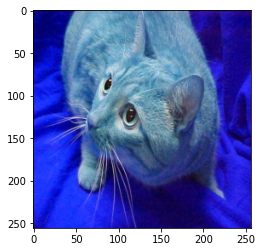

In [161]:
print(f"im shape: {im.shape}")

d = cv2.resize(im, (256, 256), interpolation = cv2.INTER_AREA)

print(f"d resized: {d.shape}")
plt.imshow(d)


In [162]:
x = d.T[:,:,:]
x.shape

(3, 256, 256)

In [163]:
x = x[None]
print(f"d[None] shape: {x.shape}")
inp = torch.FloatTensor(x/255).cuda() # torch.FloatTensor(d/255)[None].cuda()
print(f"inp shape: {inp.shape}")

d[None] shape: (1, 3, 256, 256)
inp shape: torch.Size([1, 3, 256, 256])


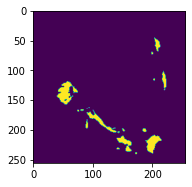

In [164]:
a = model.forward(inp.cuda())
b = a.detach()
c = b.cpu().numpy()

plt.subplot(122)
plt.imshow(c[0,:,:].squeeze(0).T>0.002)
plt.show()

In [165]:
torch.save(model.state_dict(), "./model")